In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessorV2

%matplotlib inline

In [97]:
# name, epidemicforecasting.org code, OxCGRT code
region_info = [
    ("Andorra", "AD", "AND"),
    ("Austria", "AT",  "AUT"),
    ("Bosnia and Herzegovina", "BA", "BIH"),
    ("Belgium", "BE", "BEL"),
    ("Bulgaria",  "BG", "BGR"),
    ("Switzerland", "CH", "CHE"),
    ("Czech Republic", "CZ", "CZE"),
    ("Germany", "DE", "DEU"),
    ("Denmark", "DK", "DNK"),
    ("Estonia","EE", "EST"),
    ("Spain", "ES", "ESP"),
    ("Finland", "FI", "FIN"),
    ("France", "FR", "FRA"),
    ("United Kingdom", "GB", "GBR"),
    ("Greece", "GR", "GRC"),
    ("Croatia", "HR", "HRV"),
    ("Hungary", "HU", "HUN"),
    ("Ireland", "IE", "IRL"),
    ("Israel", "IL", "ISR"),
    ("Iceland", "IS", "ISL"),
    ("Italy", "IT", "ITA"),
    ("South Korea", "KR", "KOR"),
    ("Morocco", "MA", "MAR"),
    ("Mexico","MX", "MEX"),
    ("Malaysia", "MY", "MYS"),
    ("Netherlands", "NL", "NLD"),
    ("Poland","PL", "POL"),
    ("Romania","RO", "ROU"),
    ("Serbia", "RS", "SRB"),
    ("Sweden", "SE", "SWE"),
    ("Singapore", "SG", "SGP"),
    ("Slovenia", "SI", "SVN"),
    ("Slovakia", "SK", "SVK"),
    ("South Africa", "ZA",  "ZAF")
]

# OxCGRT
oxcgrt_cm_cols = ["C1_School closing", "C1_Flag", "C4_Restrictions on gatherings", "C4_Flag", "C6_Stay at home requirements",
              "C6_Flag", "H2_Testing policy", "H3_Contact tracing"]

oxcgrt_filter = [
    ("Symptomatic Testing", [(6, [2, 3])]),
    ("Public Testing", [(6, [3])]),
#     ("Limited Contact Tracing", [(7, [2, 3])]),
    ("Extensive Contact Tracing", [(7, [2, 3])]),
    ("Gatherings lim. 1000", [(2, [2, 3, 4]), (3, [1])]),
    ("Gatherings lim. 100", [(2, [3, 4]), (3, [1])] ),
    ("Gatherings lim. 10", [(2, [4]), (3, [1])] ),
#     ("Some Schools Closed", [(0, [3, 2]), (1, [1])]),
    ("All Schools Closed", [(0, [3]), (1, [1])] ),
#     ("Stay at Home, Rec", [(4, [1, 2, 3]), (5, [1])] ),
    ("Stay at Home, Req", [(4, [2, 3]), (5, [1])] ),
]

epifor_features = [
 'Mask wearing over 70%',
 'Business suspended - some',
 'Business suspended - many',
 'Healthcare specialisation',
 'Outgroup mobility',
 'General curfew',
 'Gatherings limited to 1000',    
 'Gatherings limited to 100',
 'Gatherings limited to 10',
 'Schools and universities closed'
]

ox_epi = {
    'Stay at Home, Req':'General curfew',
    'Gatherings lim. 1000':'Gatherings limited to 1000',
    'Gatherings lim. 100':'Gatherings limited to 100',
    'Gatherings lim. 10':'Gatherings limited to 10',
    'All Schools Closed':'Schools and universities closed'
}

# ox_epi = dict()

final_features_ordered = [
    "Healthcare specialisation",
    "Symptomatic Testing",
    "Public Testing",
    "Extensive Contact Tracing",
    "Mask wearing over 70%",
    "Business suspended - some",
    "Business suspended - many",
    'Stay at Home, Req',
    'Gatherings lim. 1000',    
    'Gatherings lim. 100',
    'Gatherings lim. 10',
    'All Schools Closed',
]

dp = DataPreprocessorV2(min_num_confirmed_mask=100, min_num_active_mask=100, end_date="2020-04-20")

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures: Epidemic Forecasting              min   ... mean  ... max   ... unique
 1 Mask wearing over 70%                      0.000 ... 0.080 ... 1.000 ... [0. 1.]
 2 Business suspended - some                  0.000 ... 0.285 ... 1.000 ... [0. 1.]
 3 Business suspended - many                  0.000 ... 0.203 ... 1.000 ... [0. 1.]
 4 Healthcare specialisation                  0.000 ... 0.062 ... 1.000 ... [0. 1.]
 5 Outgroup mobility                          0.000 ... 0.326 ... 1.000 ... [0. 1.]
 6 General curfew                             0.000 ... 0.171 ... 1.000 ... [0. 1.]
 7 Gatherings limited to 1000                 0.000 ... 0.283 ... 1.000 ... [0. 1.]
 8 Gatherings limited to 100                  0.000 ... 0.253 .

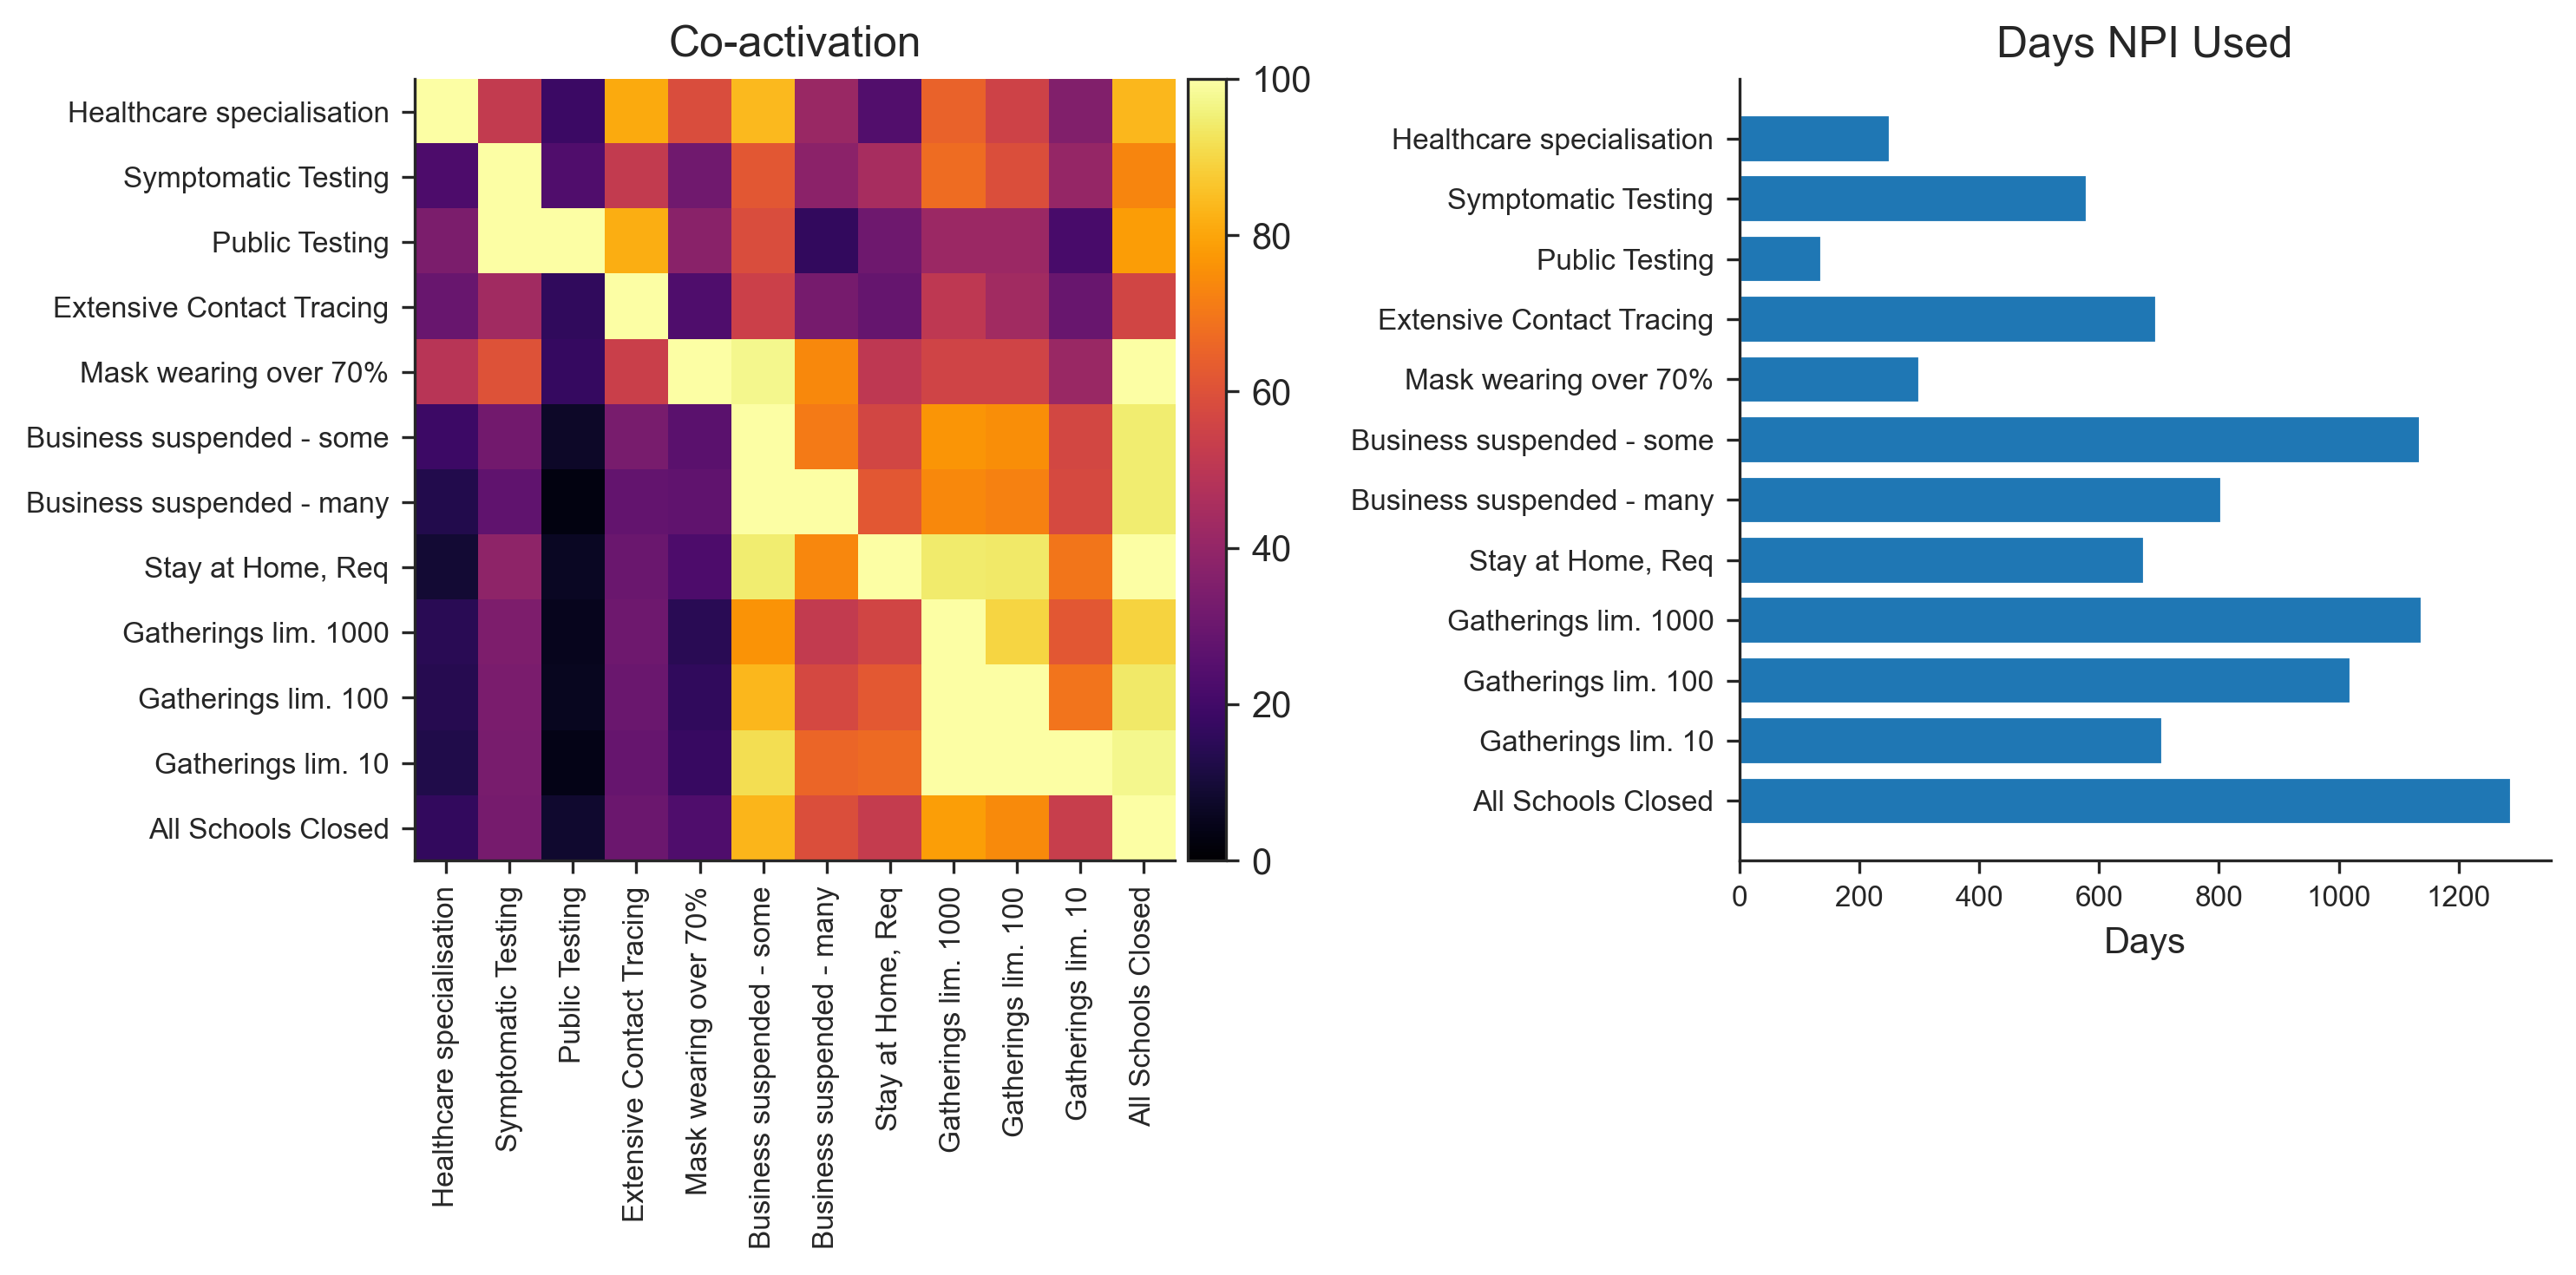

In [21]:
data = dp.preprocess_data("../../data", region_info, oxcgrt_filter, oxcgrt_cm_cols, epifor_features, final_features_ordered, ox_epi)

Expectation: 9.911713559962456
True Mean: 10.343981286371571


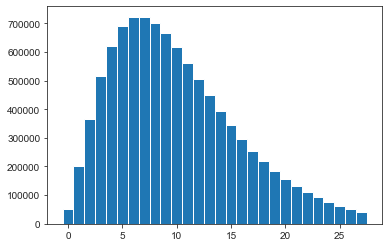

In [94]:
nRVs= 10000000
samples = np.random.gamma(shape=1.352, scale=3.77, size=nRVs) + np.random.negative_binomial(1.57, (1-0.7698), size=nRVs)
bins = np.arange(-1, 28.0)
bins += 0.5

n, _, _ = plt.hist(samples, bins);

delay_prob = n / np.sum(n)
print(f"Expectation: {np.sum([(i) * delay_prob[i] for i in range(len(delay_prob))])}")
print(f"True Mean: {np.mean(samples)}")

In [86]:
delay_prob

array([0.00509233, 0.02039664, 0.03766875, 0.0524391 , 0.06340527,
       0.07034326, 0.07361858, 0.07378182, 0.07167229, 0.06755999,
       0.06275661, 0.05731038, 0.05141595, 0.04565263, 0.04028695,
       0.03502109, 0.03030662, 0.02611754, 0.02226727, 0.0188904 ,
       0.01592167, 0.01342368, 0.01127307, 0.00934768, 0.00779801,
       0.00645582, 0.00534967, 0.00442695])

In [13]:
def mask_region_start(d, region, start):
    i = d.Rs.index(region)
    d.Active.mask[i,start:] = True
    d.Confirmed.mask[i,start:] = True
    d.Deaths.mask[i,start:] = True
    d.NewDeaths.mask[i,start:] = True

def mask_region(d, region, ndays=7):
    i = d.Rs.index(region)
    confirm_start = list(d.Confirmed.mask[i,:]).index(False)
    holdout_cutoff = confirm_start + ndays
    mask_region_start(d, region, holdout_cutoff)
    
mask_region(data, 'DE')
mask_region(data, 'ES')
mask_region(data, 'GB')
mask_region(data, 'GR')

In [106]:
with cm_effect.models.CMActive_R(data) as model:
    model.build_model()

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in ObservedConfirmedLog contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


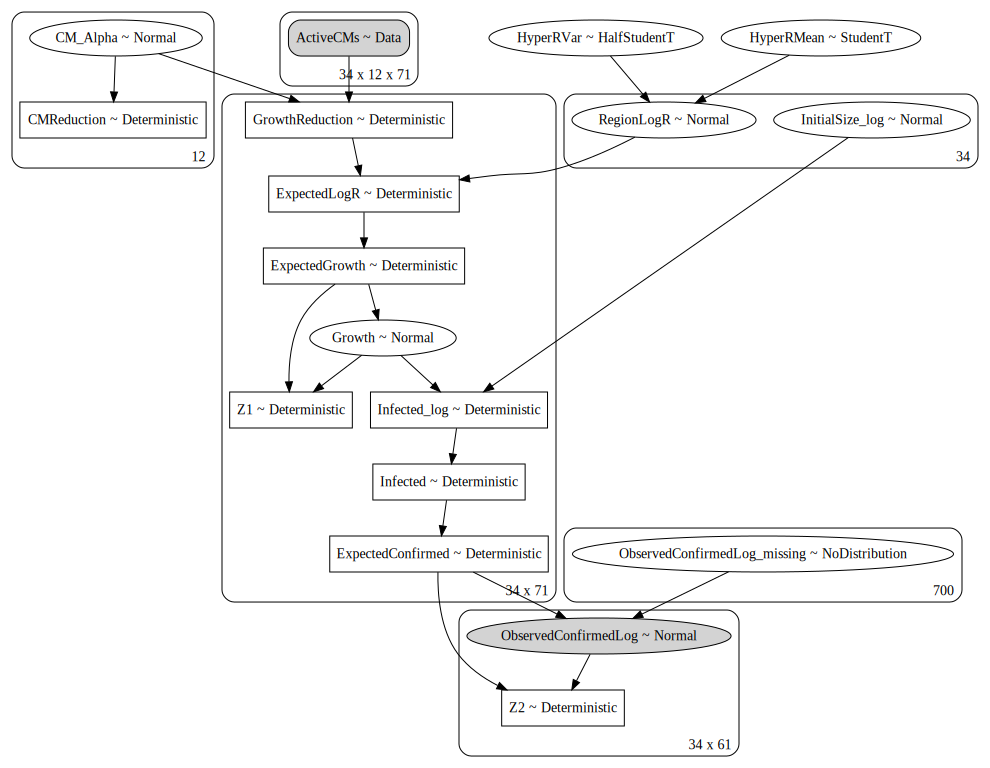

In [107]:
pm.model_to_graphviz(model).render("model-active")
pm.model_to_graphviz(model)

In [108]:
with model.model:
    model.trace = pm.sample(2000, chains=2, cores=8, init="adapt_diag", target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 8 jobs)
NUTS: [ObservedConfirmedLog_missing, InitialSize_log, Growth, RegionLogR, HyperRVar, HyperRMean, CM_Alpha]
INFO:pymc3:NUTS: [ObservedConfirmedLog_missing, InitialSize_log, Growth, RegionLogR, HyperRVar, HyperRMean, CM_Alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [18:27<00:00,  4.51draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/OxCGRT/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/OxCGRT/out


<Figure size 2100x900 with 0 Axes>

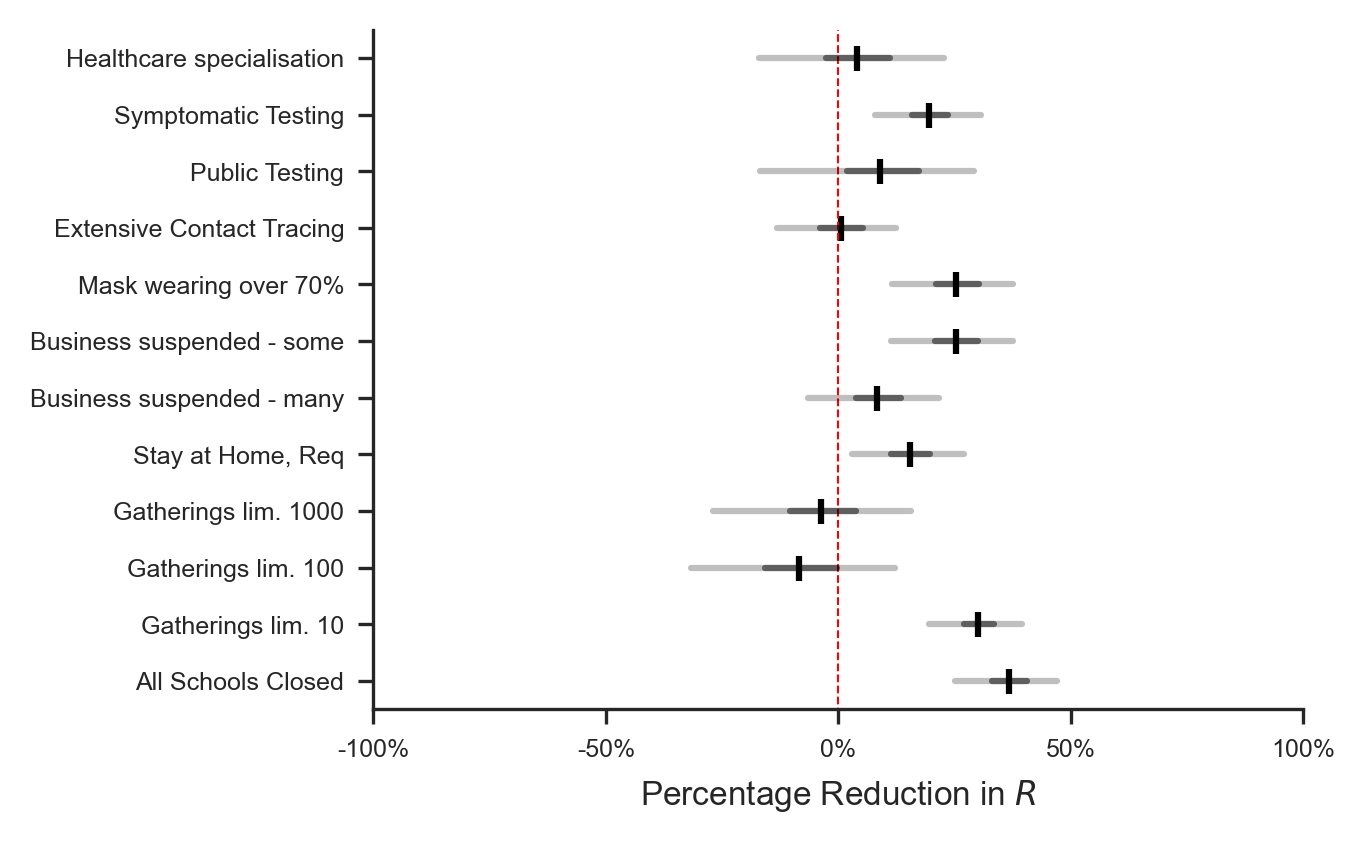

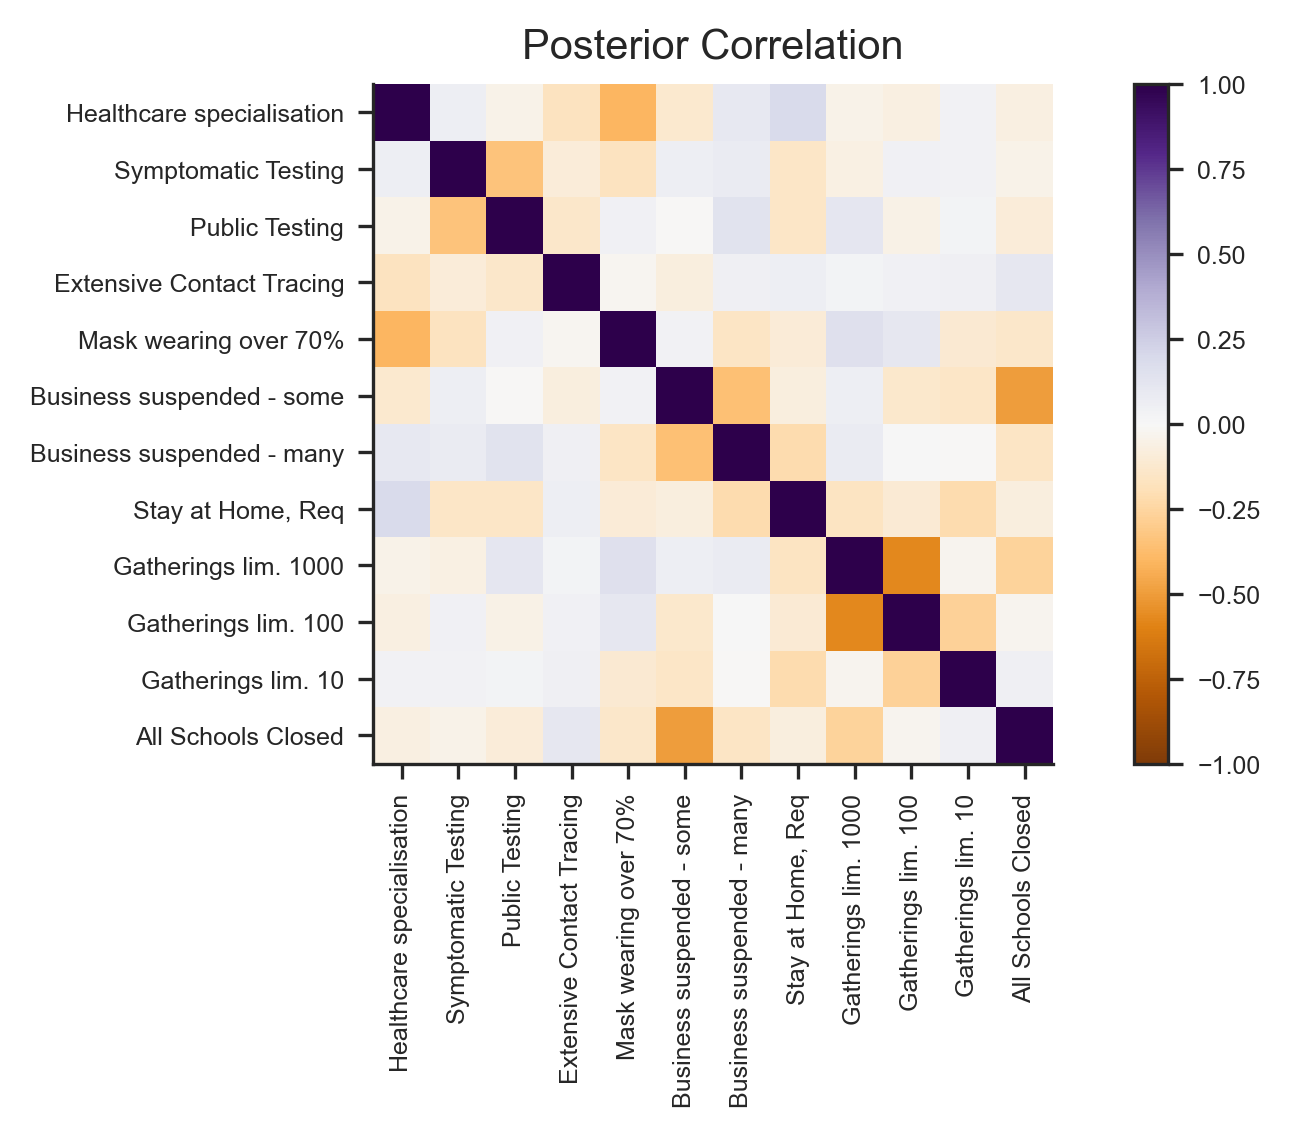

In [110]:
model.plot_effect()

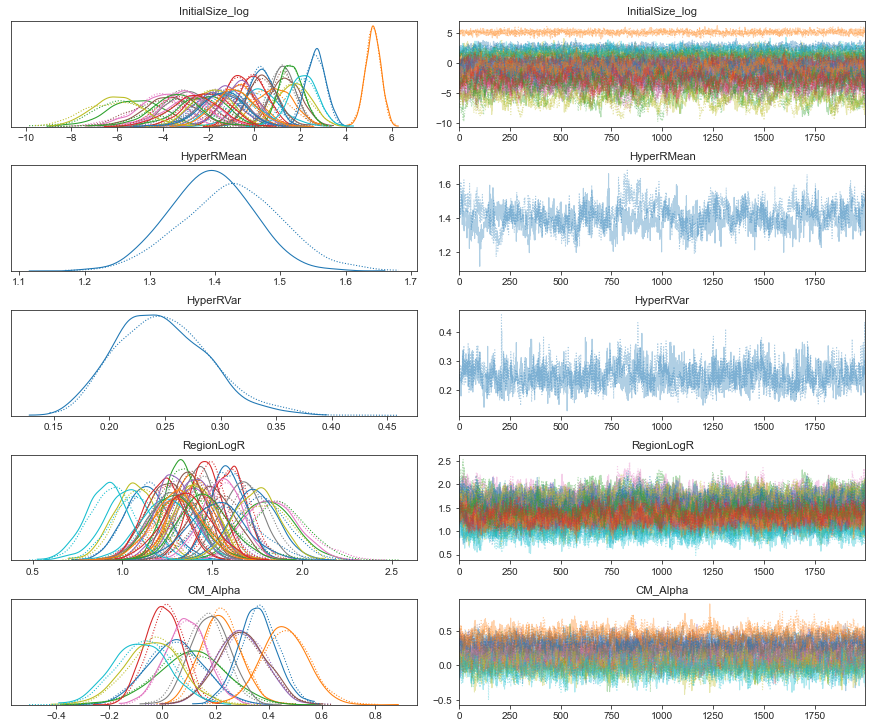

In [112]:
v =[
    'InitialSize_log',
    'HyperRMean',
    'HyperRVar',
    'RegionLogR',
    'CM_Alpha',
]

pm.traceplot(model.trace, v);

In [114]:
np.savetxt("active_results_R.csv", model.trace["CMReduction"], delimiter=",")